<a href="https://colab.research.google.com/github/LarissaRandow/PLN/blob/main/PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corpus

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 63.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# ## 2. Carregamento do Corpus
# Função para carregar os textos do repositório
def carregar_corpus():
    if not os.path.exists("corpus_readability_nlp_portuguese"):
        !git clone https://github.com/gazzola/corpus_readability_nlp_portuguese.git

    # Caminho base para os textos
    base_path = "corpus_readability_nlp_portuguese"

    # Listar todas as subpastas e arquivos
    textos = []
    labels = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                    textos.append(f.read())
                    labels.append(os.path.basename(root))  # Nome da pasta como label

    # Retornar DataFrame com textos e rótulos
    return pd.DataFrame({"text": textos, "label": labels})

# Carregar os dados
dados = carregar_corpus()
print("Dados carregados com sucesso!\n")
print(dados.head())

Cloning into 'corpus_readability_nlp_portuguese'...
remote: Enumerating objects: 2093, done.
remote: Total 2093 (delta 0), reused 0 (delta 0), pack-reused 2093 (from 1)
Receiving objects: 100% (2093/2093), 2.40 MiB | 5.40 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Dados carregados com sucesso!

                                                text                    label
0   Depois de ficarem 50 anos separados, os dois ...  2_Ensino_Fundamental_II
1  Sociologia. Apesar de não ouvirmos com tanta f...  2_Ensino_Fundamental_II
2   Se nem a fotografia era comum naquela época, ...  2_Ensino_Fundamental_II
3  O ouro da biotecnologia. Até os bebês sabem qu...  2_Ensino_Fundamental_II
4   As mudanças que se iniciaram com o renascimen...  2_Ensino_Fundamental_II



Estatísticas dos dados:
label
4_Ensino_Superior          826
3_Ensino_Medio             628
2_Ensino_Fundamental_II    325
1_Ensino_Fundamental_I     297
Name: count, dtype: int64


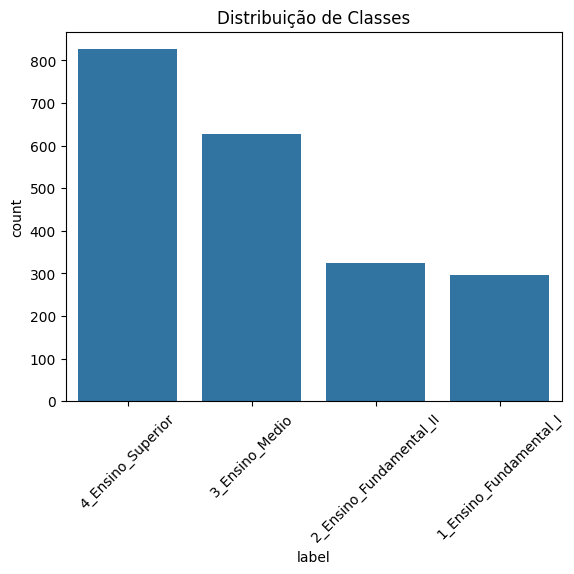

In [ ]:
# ## 3. Análise Exploratória
# Estatísticas básicas
print("\nEstatísticas dos dados:")
print(dados['label'].value_counts())

# Distribuição de classes
sns.countplot(x='label', data=dados, order=dados['label'].value_counts().index)
plt.title("Distribuição de Classes")
plt.xticks(rotation=45)
plt.show()

# Pré-processamento


In [ ]:
def process(textos):
    nlp = spacy.load('pt_core_news_sm')

    new_items = []
    with tqdm(total=len(textos), desc='Processing') as pbar:
        for item in textos:
            doc = nlp(item)
            tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and not t.is_stop]
            new_item = ' '.join(tokens)
            new_items.append(new_item)
            pbar.update(1)

    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(new_items)

    return X

# Experimento

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(dados['label'])

X = process(dados['text'])

Processing: 100%|██████████| 2076/2076 [02:41<00:00, 12.87it/s]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Relatório de Classificação:
                         precision    recall  f1-score   support

 1_Ensino_Fundamental_I       0.83      0.83      0.83        53
2_Ensino_Fundamental_II       0.85      0.72      0.78        64
         3_Ensino_Medio       0.88      0.77      0.82       128
      4_Ensino_Superior       0.86      0.99      0.92       171

               accuracy                           0.86       416
              macro avg       0.86      0.83      0.84       416
           weighted avg       0.86      0.86      0.86       416



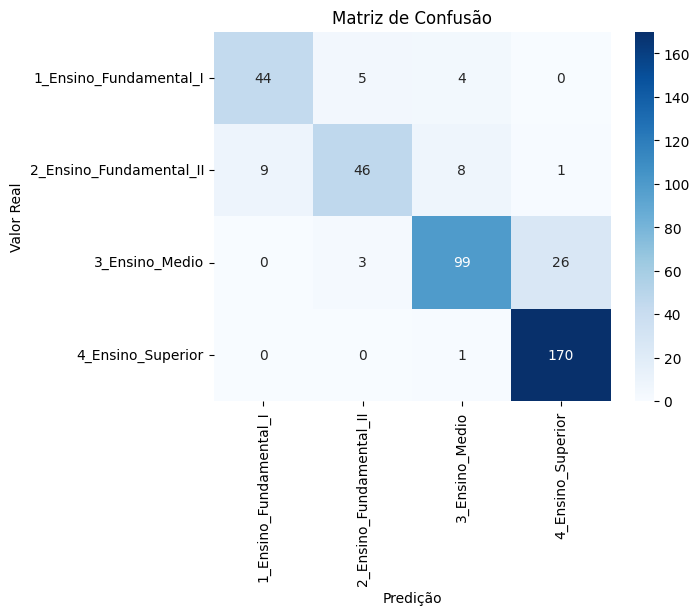

In [ ]:
# Modelo básico: Naive Bayes
modelo = MultinomialNB()
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)

# Relatório de Classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Matriz de Confusão
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Matriz de Confusão")
plt.ylabel("Valor Real")
plt.xlabel("Predição")
plt.show()

Relatório de Classificação (RF):
                         precision    recall  f1-score   support

 1_Ensino_Fundamental_I       0.84      0.92      0.88        53
2_Ensino_Fundamental_II       0.88      0.69      0.77        64
         3_Ensino_Medio       0.88      0.78      0.83       128
      4_Ensino_Superior       0.87      0.99      0.93       171

               accuracy                           0.87       416
              macro avg       0.87      0.85      0.85       416
           weighted avg       0.87      0.87      0.87       416



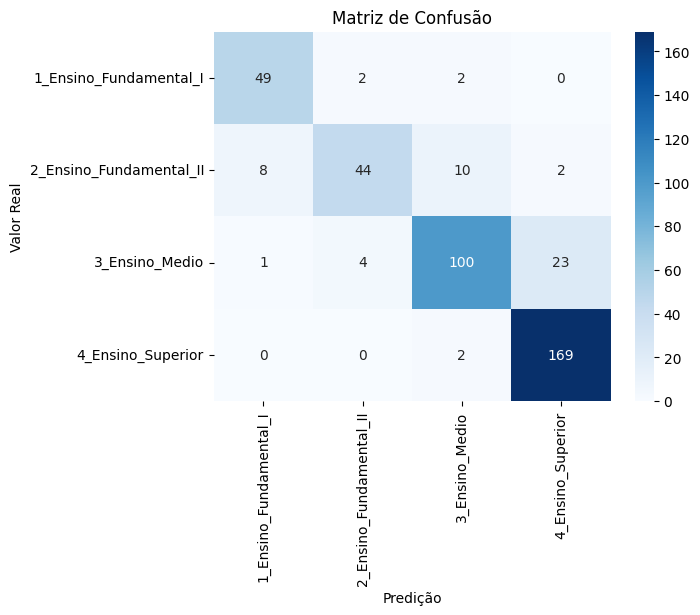

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Modelo básico: Random Forest
clf = RandomForestClassifier(n_estimators = 200)
clf.fit(X_train, y_train)

#Previsões
y_pred = clf.predict(X_test)

# Relatório de Classificação
print("Relatório de Classificação (RF):")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Matriz de Confusão
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Matriz de Confusão")
plt.ylabel("Valor Real")
plt.xlabel("Predição")
plt.show()

Relatório de Classificação (SVM):
                         precision    recall  f1-score   support

 1_Ensino_Fundamental_I       0.87      0.91      0.89        53
2_Ensino_Fundamental_II       0.88      0.78      0.83        64
         3_Ensino_Medio       0.93      0.88      0.90       128
      4_Ensino_Superior       0.93      0.99      0.96       171

               accuracy                           0.92       416
              macro avg       0.90      0.89      0.90       416
           weighted avg       0.92      0.92      0.91       416



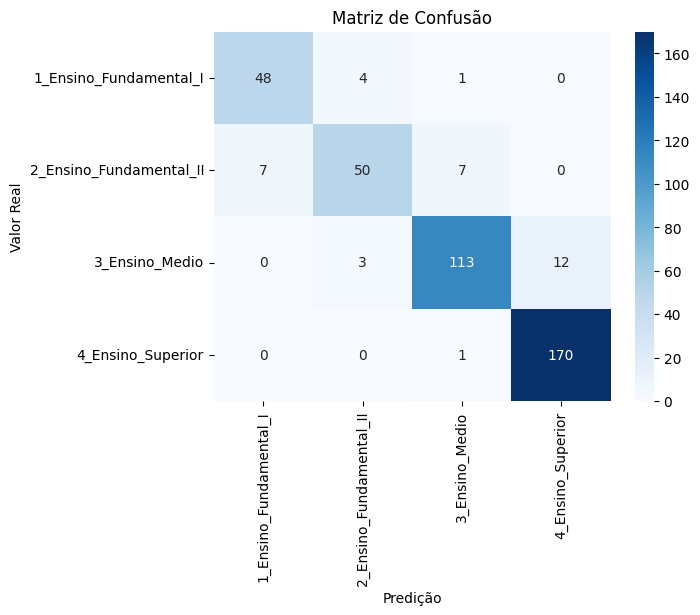

In [ ]:
from sklearn import svm

# Modelo básico: SVC
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

#Previsões
y_pred = clf.predict(X_test)

# Relatório de Classificação
print("Relatório de Classificação (SVM):")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Matriz de Confusão
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Matriz de Confusão")
plt.ylabel("Valor Real")
plt.xlabel("Predição")
plt.show()